<h1><center>Deep Learning : Assignment 05 part-b</h1>
<h1><center>MSCS18030 - Muhammad Rauf Tabassam</h1>

#Objectives
In part-2 of assignment 5, you will be performing multi-class, multi-label classification. You are required to implement focal loss for detecting infections such as COVID-19 among X-Ray images: 

1. Use CNN, pre-trained on ImageNet, to extract basic features from X-Ray images.
2. Train the classification layers in order to detect instances of Infected (COVID-19 + Pneumonia) and Normal X-Ray images.
3. Fine-tune the entire network to try to improve performance.
4. Implement focal loss


## Task 1: Finetune pre-trained CNN models
* In this task you will fine-tune two networks (ResNet-18 and VGG-16) pretrained on ImageNet weights.
* Load these models in PyTorch.
* Replace all FC layers with a fully connected network of your choice. You are free to choose the number of layers and neurons per layer.
* Finetune the model using CrossEntropy loss. Please note that default cross-entropy loss of PyTorch has a built-in Softmax. For this assignment you will not be needing softmax. So instead, use BCEWithLogitsLoss (link). This loss accepts one-hot vectors for targets. This loss automatically applies a sigmoid function.
* Now write a function for Focal Loss and use this loss instead of the Negative Log Likelihood loss for finetuning the model.
* You can also download part-1 codes of your class fellows from Github. Search for DLSpring2020 in the Github search bar. You must cite the repository if you are doing so.
* Save your model and name it as ‘vgg16_focal_loss.pth’ and ‘res18_focal_loss.pth’

Main experiments for Github are:
1. One experiment of ResNet-18 and VGG-16 each, end-to-end without focal loss
2. One experiment of ResNet-18 and VGG-16 each, end-to-end with focal loss


In [1]:
from google.colab import drive
drive.mount("./drive")

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
!unzip '/content/drive/My Drive/Copy of A_05_Part_02_Dataset.zip' #-d '/content/drive/My Drive/DL_A5b_data'

Streaming output truncated to the last 5000 lines.
  inflating: A_05_Part_02_Dataset/Train/normal/538d24ba-8a55-4445-b0d5-f9e5812fdd49.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bae9fc-3bb2-4684-b986-84bf7aa2e5a2.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bed796-1a7b-406b-b37c-d37facb41158.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c275e1-e692-4445-bb4f-b740d117712f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c369ae-d8f9-4e44-b212-c6e2dc6ef580.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53cd7c28-fe79-4537-99b5-e942987b67d1.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53d48fe7-999e-4a53-8f7e-ec5e0ffbfd59.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53e21159-fc48-450d-9377-c3dc4463a28e.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53e37b9f-3231-44e8-8bf1-56eaaa6e49c4.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53e8706e-4bd3-45d8-89e9-af18bf665e67.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53

In [0]:
data_dir = '/content/A_05_Part_02_Dataset'

In [5]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(25),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=validation_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test2', transform=test_transforms)

print("train_data: ", len(train_data))
print("validation_data: ", len(validation_data))
print("test_data: ", len(test_data))

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)


train_data:  6200
validation_data:  628
test_data:  629
Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


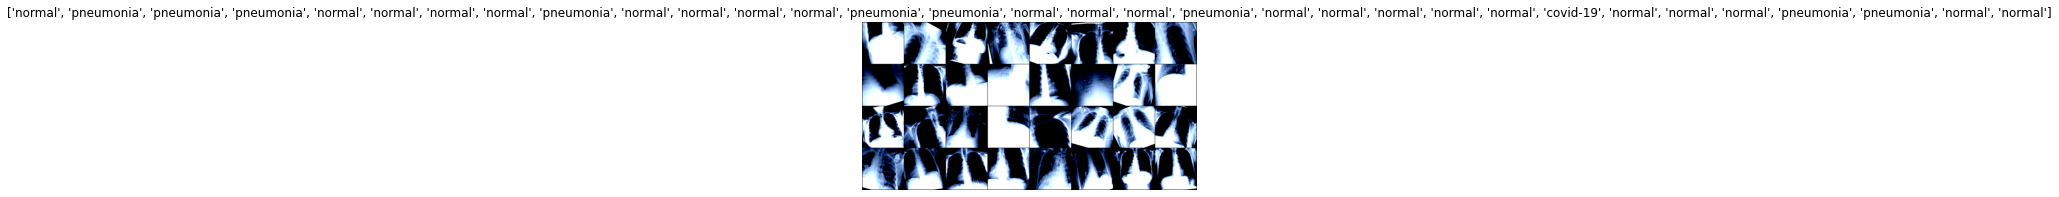

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
def Accuracy(model,loader):
    model = model.to(device)
    correct = 0
    total = 0
    lbls = []
    pred = []
    with torch.no_grad():
        for data in tqdm(loader):
            images, labels = data
            images, labels = images.to(device), one_hot(labels).to(device)
            outputs = model(images)
            predicted = torch.sigmoid(outputs.data)
            for i in range(len(predicted)):
                for j in range(len(predicted[i])):
                    if predicted[i][j] >= 0.5:
                        predicted[i][j] = 1
                    else:
                        predicted[i][j] = 0
            total += labels.size(0)
            for i in range(labels.size(0)):
                if(str(predicted[i]) == str(labels[i])):
                    correct += 1
            lbls.extend(labels.tolist())
            pred.extend(predicted.tolist())
    return correct/total, lbls, pred

def Accuracy_cpu(model,loader):
    #model = model.to(device)
    correct = 0
    total = 0
    lbls = []
    pred = []
    with torch.no_grad():
        for data in tqdm(loader):
            images, labels = data
            images, labels = images.to(device), one_hot(labels).to(device)
            outputs = model(images)
            predicted = torch.sigmoid(outputs.data)
            for i in range(len(predicted)):
                for j in range(len(predicted[i])):
                    if predicted[i][j] >= 0.5:
                        predicted[i][j] = 1
                    else:
                        predicted[i][j] = 0
            total += labels.size(0)
            for i in range(labels.size(0)):
                if(str(predicted[i]) == str(labels[i])):
                    correct += 1
            lbls.extend(labels.tolist())
            pred.extend(predicted.tolist())
    return correct/total, lbls, pred

def one_hot(label):
    one_h = torch.zeros(len(label),3)
    for i in range(len(label)):
        if label[i] == 0:
            one_h[i][0] = 1
            one_h[i][1] = 1
        elif label[i] == 1:
            one_h[i][1] = 1
        elif label[i] == 2:
            one_h[i][2] = 1
    return one_h

# Task 1: Load pretrained CNN model and fine-tune FC Layers

## 1. VGG16

### Loading pre-trained VGG16

In [8]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[-1].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
# features.extend([nn.Linear(num_features, 2000)])
# features.extend([nn.ReLU()])
# features.extend([nn.Dropout()])
# features.extend([nn.Linear(2000, 1000)])
# features.extend([nn.ReLU()])
# features.extend([nn.Dropout()])
features.extend([nn.Linear(num_features, len(class_names))])
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
vgg16.requires_grad = True

### Loss function and optimizer

In [0]:
Epochs = 30
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9) #, weight_decay=1e-5) #https://medium.com/udacity-pytorch-challengers/ideas-on-how-to-fine-tune-a-pre-trained-model-in-pytorch-184c47185a20

### Training

In [11]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
vgg16.to(device)

vgg16.train()
train_loss = []
train_accu = []
validation_loss = []
validation_accu = []

for epoch in range(Epochs):  # loop over the dataset multiple times
    # inp = input("Press 'N' to stop, anykey to continue!")
    # if inp == 'N':
    #     break
    
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #print(inputs.shape)
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = vgg16.forward(inputs)     #----> forward pass
        oh_labels = one_hot(labels).to(device)
        loss = criterion(outputs, oh_labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    train_loss.append(running_loss)
    train_accu.append(Accuracy(vgg16,trainloader)[0])
    print("Training Accuracy:",train_accu[-1])
    torch.save(vgg16.state_dict(), str(epoch)+'vgg16_without_focal_loss.pth')
    
    #validation loss
    running_loss = 0.0
    pbar = tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() 
        outputs = vgg16.forward(inputs)     #----> forward pass
        oh_labels = one_hot(labels).to(device)
        loss = criterion(outputs, oh_labels)   #----> compute loss

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validationloader.dataset),
                100. * i / len(validationloader),
                loss.data))
    validation_loss.append(running_loss) 
    validation_accu.append(Accuracy(vgg16,validationloader)[0])
    print("Validation Accuracy:",validation_accu[-1])
    
print('Finished Training')

device: cuda:0


Train Epoch: 0 [4632/6200 (99%)]	Loss: 0.290972: : 194it [01:52,  1.72it/s]
100%|██████████| 194/194 [01:46<00:00,  1.83it/s]


Training Accuracy: 0.8446774193548388


Validation Epoch: 0 [380/628 (95%)]	Loss: 0.556696: : 20it [00:09,  2.20it/s]
100%|██████████| 20/20 [00:09<00:00,  2.08it/s]

Validation Accuracy: 0.8710191082802548



Train Epoch: 1 [4632/6200 (99%)]	Loss: 0.316836: : 194it [01:48,  1.78it/s]
100%|██████████| 194/194 [01:46<00:00,  1.83it/s]


Training Accuracy: 0.863225806451613


Validation Epoch: 1 [380/628 (95%)]	Loss: 0.223999: : 20it [00:09,  2.20it/s]
100%|██████████| 20/20 [00:09<00:00,  2.10it/s]

Validation Accuracy: 0.8901273885350318



Train Epoch: 2 [4632/6200 (99%)]	Loss: 0.170623: : 194it [01:49,  1.77it/s]
100%|██████████| 194/194 [01:47<00:00,  1.80it/s]


Training Accuracy: 0.8704838709677419


Validation Epoch: 2 [380/628 (95%)]	Loss: 0.060960: : 20it [00:09,  2.20it/s]
100%|██████████| 20/20 [00:09<00:00,  2.05it/s]

Validation Accuracy: 0.9028662420382165



Train Epoch: 3 [4632/6200 (99%)]	Loss: 0.220144: : 194it [01:49,  1.77it/s]
100%|██████████| 194/194 [01:50<00:00,  1.75it/s]


Training Accuracy: 0.8770967741935484


Validation Epoch: 3 [380/628 (95%)]	Loss: 0.230711: : 20it [00:09,  2.09it/s]
100%|██████████| 20/20 [00:09<00:00,  2.02it/s]

Validation Accuracy: 0.8996815286624203



Train Epoch: 4 [4632/6200 (99%)]	Loss: 0.274526: : 194it [01:51,  1.74it/s]
100%|██████████| 194/194 [01:47<00:00,  1.81it/s]


Training Accuracy: 0.8835483870967742


Validation Epoch: 4 [380/628 (95%)]	Loss: 0.209945: : 20it [00:09,  2.20it/s]
100%|██████████| 20/20 [00:09<00:00,  2.06it/s]

Validation Accuracy: 0.8964968152866242



Train Epoch: 5 [4632/6200 (99%)]	Loss: 0.242109: : 194it [01:51,  1.74it/s]
100%|██████████| 194/194 [01:47<00:00,  1.80it/s]


Training Accuracy: 0.8846774193548387


Validation Epoch: 5 [380/628 (95%)]	Loss: 0.071251: : 20it [00:09,  2.18it/s]
100%|██████████| 20/20 [00:09<00:00,  2.09it/s]

Validation Accuracy: 0.9044585987261147



Train Epoch: 6 [4632/6200 (99%)]	Loss: 0.099476: : 194it [01:50,  1.75it/s]
100%|██████████| 194/194 [01:48<00:00,  1.79it/s]


Training Accuracy: 0.8874193548387097


Validation Epoch: 6 [380/628 (95%)]	Loss: 0.115191: : 20it [00:09,  2.20it/s]
100%|██████████| 20/20 [00:09<00:00,  2.05it/s]

Validation Accuracy: 0.9124203821656051



Train Epoch: 7 [4632/6200 (99%)]	Loss: 0.049940: : 194it [01:52,  1.72it/s]
100%|██████████| 194/194 [01:50<00:00,  1.75it/s]


Training Accuracy: 0.8916129032258064


Validation Epoch: 7 [380/628 (95%)]	Loss: 0.093226: : 20it [00:09,  2.15it/s]
100%|██████████| 20/20 [00:09<00:00,  2.06it/s]

Validation Accuracy: 0.9156050955414012



Train Epoch: 8 [4632/6200 (99%)]	Loss: 0.122631: : 194it [01:52,  1.73it/s]
100%|██████████| 194/194 [01:50<00:00,  1.76it/s]


Training Accuracy: 0.9001612903225806


Validation Epoch: 8 [380/628 (95%)]	Loss: 0.130123: : 20it [00:09,  2.13it/s]
100%|██████████| 20/20 [00:09<00:00,  2.01it/s]

Validation Accuracy: 0.9299363057324841



Train Epoch: 9 [4632/6200 (99%)]	Loss: 0.066615: : 194it [01:52,  1.73it/s]
100%|██████████| 194/194 [01:50<00:00,  1.76it/s]


Training Accuracy: 0.887258064516129


Validation Epoch: 9 [380/628 (95%)]	Loss: 0.166173: : 20it [00:09,  2.17it/s]
100%|██████████| 20/20 [00:09<00:00,  2.07it/s]

Validation Accuracy: 0.9092356687898089



Train Epoch: 10 [4632/6200 (99%)]	Loss: 0.204631: : 194it [01:52,  1.73it/s]
100%|██████████| 194/194 [01:48<00:00,  1.79it/s]


Training Accuracy: 0.8933870967741936


Validation Epoch: 10 [380/628 (95%)]	Loss: 0.321541: : 20it [00:09,  2.20it/s]
100%|██████████| 20/20 [00:09<00:00,  2.07it/s]

Validation Accuracy: 0.9092356687898089



Train Epoch: 11 [4632/6200 (99%)]	Loss: 0.103790: : 194it [01:54,  1.69it/s]
100%|██████████| 194/194 [01:52<00:00,  1.73it/s]


Training Accuracy: 0.9041935483870968


Validation Epoch: 11 [380/628 (95%)]	Loss: 0.102028: : 20it [00:09,  2.17it/s]
100%|██████████| 20/20 [00:09<00:00,  2.04it/s]

Validation Accuracy: 0.9267515923566879



Train Epoch: 12 [4632/6200 (99%)]	Loss: 0.123497: : 194it [01:53,  1.71it/s]
100%|██████████| 194/194 [01:49<00:00,  1.77it/s]


Training Accuracy: 0.8896774193548387


Validation Epoch: 12 [380/628 (95%)]	Loss: 0.058194: : 20it [00:09,  2.18it/s]
100%|██████████| 20/20 [00:09<00:00,  2.08it/s]

Validation Accuracy: 0.8901273885350318



Train Epoch: 13 [4632/6200 (99%)]	Loss: 0.114177: : 194it [01:49,  1.77it/s]
100%|██████████| 194/194 [01:47<00:00,  1.81it/s]


Training Accuracy: 0.9064516129032258


Validation Epoch: 13 [380/628 (95%)]	Loss: 0.043979: : 20it [00:09,  2.22it/s]
100%|██████████| 20/20 [00:09<00:00,  2.07it/s]

Validation Accuracy: 0.9410828025477707



Train Epoch: 14 [4632/6200 (99%)]	Loss: 0.072520: : 194it [01:50,  1.76it/s]
100%|██████████| 194/194 [01:47<00:00,  1.80it/s]


Training Accuracy: 0.9059677419354839


Validation Epoch: 14 [380/628 (95%)]	Loss: 0.225653: : 20it [00:09,  2.15it/s]
100%|██████████| 20/20 [00:09<00:00,  2.06it/s]

Validation Accuracy: 0.9426751592356688



Train Epoch: 15 [4632/6200 (99%)]	Loss: 0.218613: : 194it [01:53,  1.71it/s]
100%|██████████| 194/194 [01:47<00:00,  1.80it/s]


Training Accuracy: 0.895


Validation Epoch: 15 [380/628 (95%)]	Loss: 0.085253: : 20it [00:09,  2.22it/s]
100%|██████████| 20/20 [00:09<00:00,  2.08it/s]

Validation Accuracy: 0.928343949044586



Train Epoch: 16 [4632/6200 (99%)]	Loss: 0.083784: : 194it [01:50,  1.76it/s]
100%|██████████| 194/194 [01:47<00:00,  1.81it/s]


Training Accuracy: 0.9185483870967742


Validation Epoch: 16 [380/628 (95%)]	Loss: 0.112098: : 20it [00:09,  2.18it/s]
100%|██████████| 20/20 [00:09<00:00,  2.09it/s]

Validation Accuracy: 0.9410828025477707



Train Epoch: 17 [4632/6200 (99%)]	Loss: 0.034210: : 194it [01:49,  1.77it/s]
100%|██████████| 194/194 [01:48<00:00,  1.79it/s]


Training Accuracy: 0.9133870967741935


Validation Epoch: 17 [380/628 (95%)]	Loss: 0.013276: : 20it [00:09,  2.17it/s]
100%|██████████| 20/20 [00:09<00:00,  2.05it/s]

Validation Accuracy: 0.9299363057324841



Train Epoch: 18 [4632/6200 (99%)]	Loss: 0.215095: : 194it [01:50,  1.75it/s]
100%|██████████| 194/194 [01:48<00:00,  1.78it/s]


Training Accuracy: 0.9156451612903226


Validation Epoch: 18 [380/628 (95%)]	Loss: 0.060773: : 20it [00:09,  2.16it/s]
100%|██████████| 20/20 [00:09<00:00,  2.06it/s]

Validation Accuracy: 0.9426751592356688



Train Epoch: 19 [4632/6200 (99%)]	Loss: 0.116216: : 194it [01:51,  1.74it/s]
100%|██████████| 194/194 [01:49<00:00,  1.77it/s]


Training Accuracy: 0.9190322580645162


Validation Epoch: 19 [380/628 (95%)]	Loss: 0.192449: : 20it [00:09,  2.19it/s]
100%|██████████| 20/20 [00:09<00:00,  2.06it/s]

Validation Accuracy: 0.9347133757961783



Train Epoch: 20 [4632/6200 (99%)]	Loss: 0.233443: : 194it [01:51,  1.74it/s]
100%|██████████| 194/194 [01:50<00:00,  1.76it/s]


Training Accuracy: 0.9095161290322581


Validation Epoch: 20 [380/628 (95%)]	Loss: 0.225602: : 20it [00:09,  2.12it/s]
100%|██████████| 20/20 [00:09<00:00,  2.04it/s]

Validation Accuracy: 0.928343949044586



Train Epoch: 21 [4632/6200 (99%)]	Loss: 0.068402: : 194it [01:50,  1.76it/s]
100%|██████████| 194/194 [01:47<00:00,  1.80it/s]


Training Accuracy: 0.9083870967741936


Validation Epoch: 21 [380/628 (95%)]	Loss: 0.015549: : 20it [00:08,  2.22it/s]
100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

Validation Accuracy: 0.947452229299363



Train Epoch: 22 [4632/6200 (99%)]	Loss: 0.115735: : 194it [01:49,  1.77it/s]
100%|██████████| 194/194 [01:47<00:00,  1.81it/s]


Training Accuracy: 0.9167741935483871


Validation Epoch: 22 [380/628 (95%)]	Loss: 0.095235: : 20it [00:09,  2.21it/s]
100%|██████████| 20/20 [00:09<00:00,  2.09it/s]

Validation Accuracy: 0.9394904458598726



Train Epoch: 23 [4632/6200 (99%)]	Loss: 0.050402: : 194it [01:51,  1.75it/s]
100%|██████████| 194/194 [01:49<00:00,  1.76it/s]


Training Accuracy: 0.9235483870967742


Validation Epoch: 23 [380/628 (95%)]	Loss: 0.079690: : 20it [00:09,  2.14it/s]
100%|██████████| 20/20 [00:09<00:00,  2.07it/s]

Validation Accuracy: 0.9490445859872612



Train Epoch: 24 [4632/6200 (99%)]	Loss: 0.151686: : 194it [01:51,  1.74it/s]
100%|██████████| 194/194 [01:48<00:00,  1.79it/s]


Training Accuracy: 0.9025806451612903


Validation Epoch: 24 [380/628 (95%)]	Loss: 0.177852: : 20it [00:09,  2.18it/s]
100%|██████████| 20/20 [00:09<00:00,  2.09it/s]

Validation Accuracy: 0.928343949044586



Train Epoch: 25 [4632/6200 (99%)]	Loss: 0.069857: : 194it [01:49,  1.77it/s]
100%|██████████| 194/194 [01:46<00:00,  1.82it/s]


Training Accuracy: 0.9248387096774193


Validation Epoch: 25 [380/628 (95%)]	Loss: 0.025118: : 20it [00:09,  2.17it/s]
100%|██████████| 20/20 [00:09<00:00,  2.09it/s]

Validation Accuracy: 0.9506369426751592



Train Epoch: 26 [4632/6200 (99%)]	Loss: 0.113323: : 194it [01:53,  1.71it/s]
100%|██████████| 194/194 [01:50<00:00,  1.76it/s]


Training Accuracy: 0.9198387096774193


Validation Epoch: 26 [380/628 (95%)]	Loss: 0.032542: : 20it [00:09,  2.17it/s]
100%|██████████| 20/20 [00:09<00:00,  2.01it/s]

Validation Accuracy: 0.9522292993630573



Train Epoch: 27 [4632/6200 (99%)]	Loss: 0.064174: : 194it [01:53,  1.72it/s]
100%|██████████| 194/194 [01:48<00:00,  1.79it/s]


Training Accuracy: 0.9295161290322581


Validation Epoch: 27 [380/628 (95%)]	Loss: 0.101190: : 20it [00:09,  2.16it/s]
100%|██████████| 20/20 [00:09<00:00,  2.03it/s]

Validation Accuracy: 0.947452229299363



Train Epoch: 28 [4632/6200 (99%)]	Loss: 0.040482: : 194it [01:50,  1.76it/s]
100%|██████████| 194/194 [01:47<00:00,  1.81it/s]


Training Accuracy: 0.9193548387096774


Validation Epoch: 28 [380/628 (95%)]	Loss: 0.081145: : 20it [00:09,  2.16it/s]
100%|██████████| 20/20 [00:09<00:00,  2.09it/s]

Validation Accuracy: 0.9426751592356688



Train Epoch: 29 [4632/6200 (99%)]	Loss: 0.035041: : 194it [01:49,  1.77it/s]
100%|██████████| 194/194 [01:48<00:00,  1.79it/s]


Training Accuracy: 0.92


Validation Epoch: 29 [380/628 (95%)]	Loss: 0.055642: : 20it [00:08,  2.22it/s]
100%|██████████| 20/20 [00:09<00:00,  2.09it/s]

Validation Accuracy: 0.9490445859872612
Finished Training


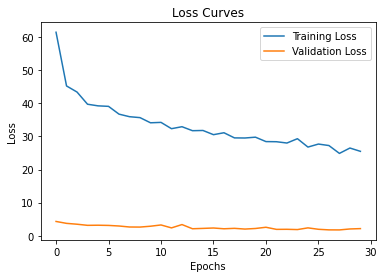

In [12]:
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')
plt.show()

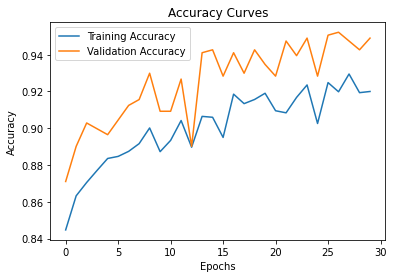

In [13]:
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(train_accu, label='Training Accuracy')
plt.plot(validation_accu, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

# Testing

In [37]:
# #print("Calculating Training Accuracy")
# train_accuracy = Accuracy(vgg16,trainloader)
# print("Training Accuracy",train_accuracy[0])

# #print("Calculating Validation Accuracy")
# valid_accuracy = Accuracy(vgg16,validationloader)
# print("Validation Accuracy",valid_accuracy[0])

print("Calcualting Testing Results")
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
test_accuracy = Accuracy(vgg16,testloader)
print("covid patiens:", test_accuracy[0])
t_out = test_accuracy[-1]

report = []
for i in range(len(test_data.imgs)):
    label = (test_data.imgs[i][0].split('/')[-1])
    report.append([label,t_out[i][0],t_out[i][1],t_out[i][2]])
print("Creating CSV report")
import csv
with open('report_vgg16_without_focal_loss.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(report)
print("CSV report created")







  0%|          | 0/629 [00:00<?, ?it/s]





  1%|          | 4/629 [00:00<00:16, 38.88it/s]

Calcualting Testing Results








  1%|▏         | 9/629 [00:00<00:18, 33.34it/s]





  2%|▏         | 14/629 [00:00<00:17, 35.47it/s]





  3%|▎         | 19/629 [00:00<00:16, 37.24it/s]





  4%|▍         | 24/629 [00:00<00:15, 38.34it/s]





  5%|▍         | 29/629 [00:00<00:15, 39.64it/s]





  5%|▌         | 34/629 [00:00<00:14, 40.67it/s]





  6%|▌         | 39/629 [00:01<00:14, 41.24it/s]





  7%|▋         | 43/629 [00:01<00:14, 40.74it/s]





  8%|▊         | 48/629 [00:01<00:13, 41.53it/s]





  8%|▊         | 53/629 [00:01<00:13, 41.98it/s]





  9%|▉         | 58/629 [00:01<00:13, 42.99it/s]





 10%|█         | 63/629 [00:01<00:13, 42.77it/s]





 11%|█         | 68/629 [00:01<00:13, 42.28it/s]





 12%|█▏        | 73/629 [00:01<00:13, 42.45it/s]





 12%|█▏        | 78/629 [00:01<00:12, 42.71it/s]





 13%|█▎        | 83/629 [00:02<00:12, 42.45it/s]





 14%|█▍        | 88/629 [00:02<00:12, 41.94it/s]





 15%|█▍        | 93/629 [00:02<00:12, 43.14it/s]





 16%|█▌        | 98/629

covid patiens: 0.022257551669316374
Creating CSV report
CSV report created


In [36]:
test_data.imgs[0][0]

'/content/A_05_Part_02_Dataset/Test2/Test/0.png'

In [0]:
def ConfusionMatrix(y_true,y_pred):
    for i in range(len(y_true)):
        y_true[i] = str(y_true[i])
        y_pred[i] = str(y_pred[i])
    print("set: y_pred", set(y_pred))
    print("set: y_true", set(y_true))
    from sklearn.metrics import confusion_matrix, classification_report
    print(confusion_matrix(y_true,y_pred))
    print("-----------------------------------------")
    print(classification_report(y_true,y_pred))

In [30]:
ConfusionMatrix(train_accuracy[1],train_accuracy[2])

set: y_pred {'[0.0, 1.0, 0.0]', '[1.0, 0.0, 1.0]', '[1.0, 1.0, 0.0]', '[0.0, 0.0, 1.0]', '[0.0, 1.0, 1.0]', '[0.0, 0.0, 0.0]'}
set: y_true {'[0.0, 1.0, 0.0]', '[0.0, 0.0, 1.0]', '[1.0, 1.0, 0.0]'}
[[   0    0    0    0    0    0]
 [  10 1672  307   10    0    1]
 [   3   55 3939    3    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0   55   58    2    1   84]]
-----------------------------------------
                 precision    recall  f1-score   support

[0.0, 0.0, 0.0]       0.00      0.00      0.00         0
[0.0, 0.0, 1.0]       0.94      0.84      0.88      2000
[0.0, 1.0, 0.0]       0.92      0.98      0.95      4000
[0.0, 1.0, 1.0]       0.00      0.00      0.00         0
[1.0, 0.0, 1.0]       0.00      0.00      0.00         0
[1.0, 1.0, 0.0]       0.99      0.42      0.59       200

       accuracy                           0.92      6200
      macro avg       0.47      0.37      0.40      6200
   weighted avg       0.92      0.92      0.92 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
ConfusionMatrix(valid_accuracy[1],valid_accuracy[2])

set: y_pred {'[0.0, 1.0, 0.0]', '[0.0, 0.0, 1.0]', '[1.0, 1.0, 0.0]', '[0.0, 0.0, 0.0]'}
set: y_true {'[0.0, 1.0, 0.0]', '[0.0, 0.0, 1.0]', '[1.0, 1.0, 0.0]'}
[[  0   0   0   0]
 [  1 184  15   0]
 [  2   4 393   1]
 [  0   3  11  14]]
-----------------------------------------
                 precision    recall  f1-score   support

[0.0, 0.0, 0.0]       0.00      0.00      0.00         0
[0.0, 0.0, 1.0]       0.96      0.92      0.94       200
[0.0, 1.0, 0.0]       0.94      0.98      0.96       400
[1.0, 1.0, 0.0]       0.93      0.50      0.65        28

       accuracy                           0.94       628
      macro avg       0.71      0.60      0.64       628
   weighted avg       0.95      0.94      0.94       628



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
